In [1]:
from data import *
from classifiers import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [2]:
metadata_train, experiments_train = load_data(os.path.join("..", "data", "train"), "")
truth_train, metadata_train = categorize_metadata(metadata_train)
metadata_test, experiments_test = load_data(os.path.join("..", "data", "test"), "")
truth_test, metadata_test = categorize_metadata(metadata_test)

# Look for optimal classifier parameters for arbitrary processing parameters

In [3]:
process_params = {
    'baseline_lam': 10,
    'baseline_p': 1e-2,
    'smooth_window_length': 7,
    'smooth_polyorder': 3
}
X_train, X_test = process_train_test(process_params, experiments_train, metadata_train, experiments_test, metadata_test, scale=True)

In [4]:
param_grid = {
    'n_estimators': range(1, 501, 50),
    'max_depth': range(1, 21, 5)
}

clf = RandomForestClassifier()

grid_clf = GridSearchCV(clf, param_grid, cv=5, verbose=1)
_ = grid_clf.fit(X_train, truth_train.to_numpy().ravel())

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [5]:
print(grid_clf.best_params_)
grid_clf.cv_results_

{'max_depth': 6, 'n_estimators': 251}


{'mean_fit_time': array([0.0109684 , 0.14558845, 0.29107876, 0.44401574, 0.62983117,
        0.90464044, 1.30349817, 1.48963833, 1.51754761, 1.67650762,
        0.017976  , 0.6056911 , 1.19775443, 1.80292883, 2.30820637,
        2.88896217, 3.82544417, 4.70413437, 4.97188001, 5.21848907,
        0.01667333, 0.51310201, 1.01425571, 1.49391861, 1.99586353,
        2.51128693, 2.98905706, 3.46806045, 3.92700777, 5.75010052,
        0.02581043, 0.72380571, 1.39286752, 2.20498114, 2.93115969,
        3.56387682, 4.11949415, 4.70615325, 5.38364735, 5.85019794]),
 'std_fit_time': array([0.00155099, 0.00615019, 0.00861202, 0.02400559, 0.06239083,
        0.13825715, 0.04239042, 0.1053701 , 0.04325728, 0.06241927,
        0.00243662, 0.02251424, 0.04135128, 0.03924291, 0.02104245,
        0.01695606, 0.21097914, 0.29014807, 0.27792858, 0.88843571,
        0.00131477, 0.02522849, 0.00494415, 0.01328549, 0.03210607,
        0.06383789, 0.03718216, 0.1099683 , 0.03155994, 1.04643212,
        0.002

In [6]:
evaluate_classifier_params(RandomForestClassifier, grid_clf.best_params_, X_train, truth_train, X_test, truth_test, iters=20)

(1.0, 0.9494350282485879)

# Look for optimal processing parameters

In [7]:
param_grid = {
    'baseline_lam': [1, 5, 10, 15, 20],
    'baseline_p': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    'smooth_window_length': [3,5,9,15,21],
    'smooth_polyorder': [3,5,9,15,21],
    'n_estimators': [grid_clf.best_params_['n_estimators']], #range(1, 101, 100),
    'max_depth': [grid_clf.best_params_['max_depth']] #range(5, 16, 5)
}
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    results = param_grid_search(RandomForestClassifier, param_grid, experiments_train, metadata_train, truth_train, cv=5)

[{'baseline_lam': 1, 'baseline_p': 0.1, 'max_depth': 6, 'n_estimators': 251, 'smooth_polyorder': 3, 'smooth_window_length': 5}, {'fit_time': array([2.26244473, 2.45940638, 2.25255084, 2.57544661, 3.4344821 ]), 'score_time': array([0.01044631, 0.00634313, 0.0092411 , 0.02027798, 0.01560187]), 'estimator': [RandomForestClassifier(max_depth=6, n_estimators=251), RandomForestClassifier(max_depth=6, n_estimators=251), RandomForestClassifier(max_depth=6, n_estimators=251), RandomForestClassifier(max_depth=6, n_estimators=251), RandomForestClassifier(max_depth=6, n_estimators=251)], 'test_score': array([0.87735849, 0.85849057, 0.88679245, 0.9047619 , 0.86666667])}]
[{'baseline_lam': 1, 'baseline_p': 0.1, 'max_depth': 6, 'n_estimators': 251, 'smooth_polyorder': 3, 'smooth_window_length': 9}, {'fit_time': array([3.24201298, 3.3379643 , 3.46586609, 3.36105418, 3.31168151]), 'score_time': array([0.0149982 , 0.01619148, 0.01564789, 0.01617694, 0.01615047]), 'estimator': [RandomForestClassifier(max

In [8]:
k = 0
best_params = dict()
for r in results:
    mean = np.mean(r[1]['test_score'])
    if mean > k:
        k = mean
        best_params = r[0]
k, best_params

(0.9735489667565138,
 {'baseline_lam': 5,
  'baseline_p': 0.001,
  'max_depth': 6,
  'n_estimators': 251,
  'smooth_polyorder': 3,
  'smooth_window_length': 9})

In [9]:
process_params = {key: best_params[key] for key in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
classifier_params = {key: best_params[key] for key in best_params.keys() if key not in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
X_train, X_test = process_train_test(process_params, experiments_train, metadata_train, experiments_test, metadata_test, scale=True)
evaluate_classifier_params(RandomForestClassifier, classifier_params, X_train, truth_train, X_test, truth_test, iters=20)

(1.0, 0.969774011299435)

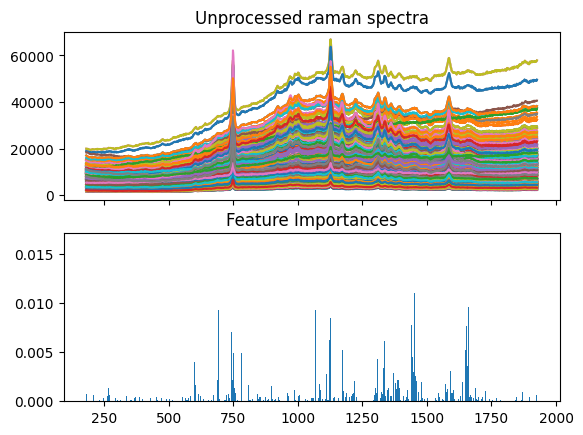

In [64]:
clf = RandomForestClassifier(**classifier_params)
clf.fit(X_train, truth_train.to_numpy().ravel())
fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(experiments_train.columns.astype(int), experiments_train.transpose())
axs[0].set_title('Unprocessed raman spectra')
axs[1].bar(experiments_train.columns.astype(int), clf.feature_importances_[9:])
_ = axs[1].set_title('Feature Importances')
plt.savefig('../images/random_forest/feature_importance.svg', format='svg', dpi=1200)

1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5
10.0
10.5
11.0
11.5
12.0
12.5
13.0
13.5
14.0
14.5
15.0
15.5
16.0
16.5
17.0
17.5
18.0
18.5
19.0
19.5
20.0


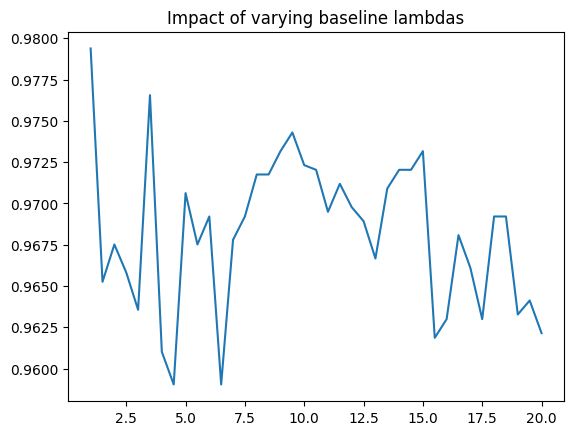

In [16]:
to_plot = []
params_history = []
params = best_params.copy()
for baseline_lam in range(2, 41):
    params['baseline_lam'] = baseline_lam/2
    params_history.append(params['baseline_lam'])
    print(params['baseline_lam'])
    process_params = {key: params[key] for key in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    classifier_params = {key: params[key] for key in best_params.keys() if key not in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    X_train, X_test = process_train_test(process_params, experiments_train, metadata_train, experiments_test, metadata_test, scale=True)
    to_plot.append(evaluate_classifier_params(RandomForestClassifier, classifier_params, X_train, truth_train, X_test, truth_test, iters=20)[1])
best_params['baseline_lam'] = params_history[to_plot.index(max(to_plot))]
_ = plt.plot(np.array(range(2, 41))/2, to_plot)
_ = plt.title("Impact of varying baseline lambdas")
plt.savefig('../images/random_forest/vary_baseline_lambda.svg', format='svg', dpi=1200)

0.999997697417558
0.3162270378763362
0.09999976974175581
0.03162270378763363
0.009999976974175576
0.003162270378763361
0.0009999976974175576
0.0003162270378763361
9.999976974175576e-05
3.162270378763361e-05


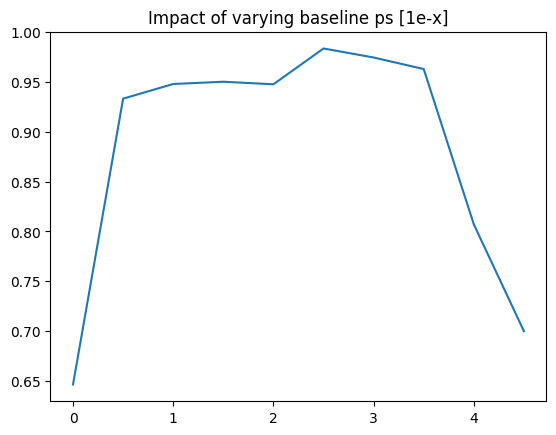

In [20]:
to_plot = []
params_history = []
params = best_params.copy()
for baseline_p in range(10):
    params['baseline_p'] = 10**(-baseline_p/2-0.000001)
    params_history.append(params['baseline_p'])
    print(params['baseline_p'])
    process_params = {key: params[key] for key in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    classifier_params = {key: params[key] for key in best_params.keys() if key not in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    X_train, X_test = process_train_test(process_params, experiments_train, metadata_train, experiments_test, metadata_test, scale=True)
    to_plot.append(evaluate_classifier_params(RandomForestClassifier, classifier_params, X_train, truth_train, X_test, truth_test, iters=20)[1])
best_params['baseline_p'] = params_history[to_plot.index(max(to_plot))]
_ = plt.plot(np.array(range(10))/2, to_plot)
_ = plt.title("Impact of varying baseline ps [1e-x]")
plt.savefig('../images/random_forest/vary_baseline_p.svg', format='svg', dpi=1200)

3
4
5
6
7
8


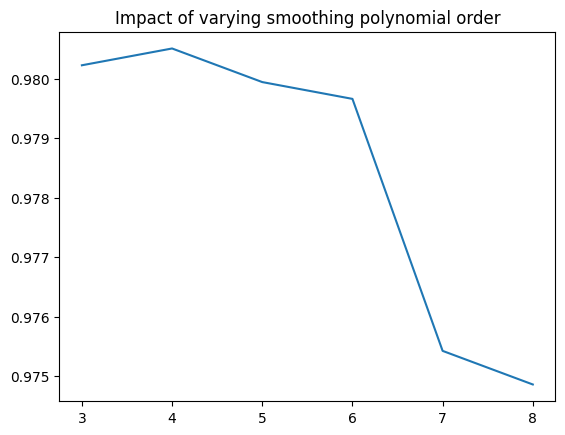

In [22]:
to_plot = []
params_history = []
params = best_params.copy()
for smooth_polyorder in range(3, params['smooth_window_length']):
    params['smooth_polyorder'] = smooth_polyorder
    params_history.append(params['smooth_polyorder'])
    print(params['smooth_polyorder'])
    process_params = {key: params[key] for key in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    classifier_params = {key: params[key] for key in best_params.keys() if key not in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    X_train, X_test = process_train_test(process_params, experiments_train, metadata_train, experiments_test, metadata_test, scale=True)
    to_plot.append(evaluate_classifier_params(RandomForestClassifier, classifier_params, X_train, truth_train, X_test, truth_test, iters=20)[1])
best_params['smooth_polyorder'] = params_history[to_plot.index(max(to_plot))]
_ = plt.plot(np.array(range(3, params['smooth_window_length'])), to_plot)
_ = plt.title("Impact of varying smoothing polynomial order")
plt.savefig('../images/random_forest/vary_smooth_order.svg', format='svg', dpi=1200)

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


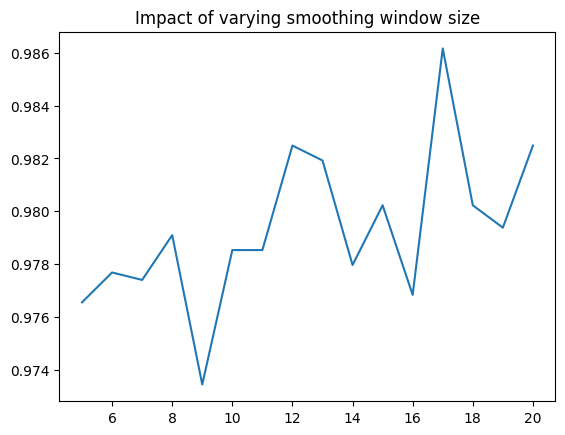

In [23]:
to_plot = []
params_history = []
params = best_params.copy()
for smooth_window_length in range(params['smooth_polyorder']+1, 21):
    params['smooth_window_length'] = smooth_window_length
    params_history.append(params['smooth_window_length'])
    print(params['smooth_window_length'])
    process_params = {key: params[key] for key in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    classifier_params = {key: params[key] for key in best_params.keys() if key not in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    X_train, X_test = process_train_test(process_params, experiments_train, metadata_train, experiments_test, metadata_test, scale=True)
    to_plot.append(evaluate_classifier_params(RandomForestClassifier, classifier_params, X_train, truth_train, X_test, truth_test, iters=20)[1])
best_params['smooth_window_length'] = params_history[to_plot.index(max(to_plot))]
_ = plt.plot(range(params['smooth_polyorder']+1, 21), to_plot)
_ = plt.title("Impact of varying smoothing window size")
plt.savefig('../images/random_forest/vary_smooth_window.svg', format='svg', dpi=1200)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


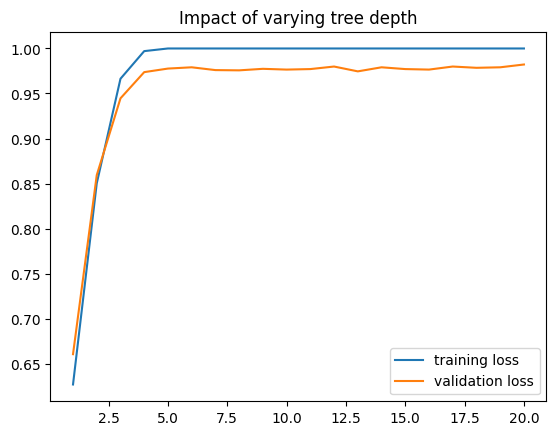

In [25]:
to_plot = []
params_history = []
params = best_params.copy()
for max_depth in range(1, 21):
    params['max_depth'] = max_depth
    params_history.append(params['max_depth'])
    print(params['max_depth'])
    process_params = {key: params[key] for key in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    classifier_params = {key: params[key] for key in best_params.keys() if key not in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    X_train, X_test = process_train_test(process_params, experiments_train, metadata_train, experiments_test, metadata_test, scale=True)
    to_plot.append(evaluate_classifier_params(RandomForestClassifier, classifier_params, X_train, truth_train, X_test, truth_test, iters=20))
best_params['smooth_window_length'] = params_history[list(map(lambda x: x[1], to_plot)).index(max(map(lambda x: x[1], to_plot)))]
_ = plt.plot(range(1, 21), to_plot)
_ = plt.title("Impact of varying tree depth")
_ = plt.legend(["training loss", "validation loss"])
plt.savefig('../images/random_forest/vary_tree_depth.svg', format='svg', dpi=1200)

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191


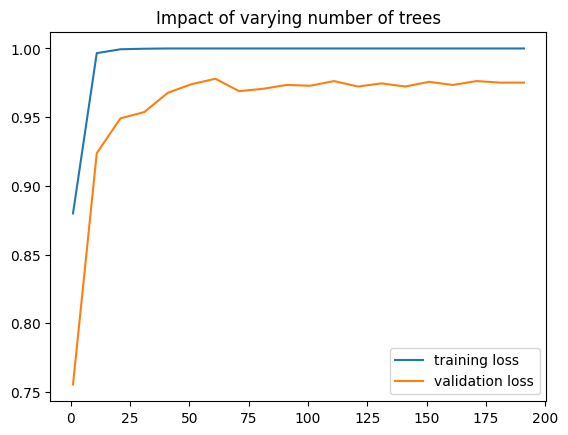

In [28]:
to_plot = []
params_history = []
params = best_params.copy()
for n_estimators in range(1, 201, 10):
    params['n_estimators'] = n_estimators
    params_history.append(params['n_estimators'])
    print(params['n_estimators'])
    process_params = {key: params[key] for key in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    classifier_params = {key: params[key] for key in best_params.keys() if key not in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    X_train, X_test = process_train_test(process_params, experiments_train, metadata_train, experiments_test, metadata_test, scale=True)
    to_plot.append(evaluate_classifier_params(RandomForestClassifier, classifier_params, X_train, truth_train, X_test, truth_test, iters=10))
best_params['n_estimators'] = params_history[list(map(lambda x: x[1], to_plot)).index(max(map(lambda x: x[1], to_plot)))]
_ = plt.plot(range(1, 201, 10), to_plot)
_ = plt.title("Impact of varying number of trees")
_ = plt.legend(["training loss", "validation loss"])
plt.savefig('../images/random_forest/vary_tree_number.svg', format='svg', dpi=1200)

In [32]:
process_params = {key: best_params[key] for key in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
classifier_params = {key: best_params[key] for key in best_params.keys() if key not in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
X_train, X_test = process_train_test(process_params, experiments_train, metadata_train, experiments_test, metadata_test, scale=True)
evaluate_classifier_params(RandomForestClassifier, classifier_params, X_train, truth_train, X_test, truth_test, iters=20)

(1.0, 0.9720338983050848)

# Removing data

In [36]:
process_params = {key: best_params[key] for key in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
X_train, X_test = process_train_test(process_params, experiments_train, metadata_train, experiments_test, metadata_test, scale=False)

In [37]:
param_grid = {
    'n_estimators': range(1, 201, 100),
    'max_depth': range(5, 21, 5)
}
results = []
X_size = []
for min_std in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]:
    to_drop = X_train.std() > min_std
    X_train_small = X_train.loc[:, to_drop]
    X_size.append(len(X_train_small.columns))

    scaler = StandardScaler()
    scaler.fit(X_train_small)
    X_train_small = scaler.transform(X_train_small)
    
    hyper_results = []
    for params in ParameterGrid(param_grid):
        try:
            clf = RandomForestClassifier(**params)
            hyper_results.append([params, cross_validate(clf, X_train_small, truth_train.to_numpy().ravel(), cv=20, return_estimator=True)])
        except Exception as e:
            pass  # print(params, e)
        
    crossval_res = 0
    best_params = dict()
    for r in hyper_results:
        mean = np.mean(r[1]['test_score'])
        if mean > crossval_res:
            crossval_res = mean
            best_params = r[0]
    
    print(min_std, X_size[-1], crossval_res)
    results.append(crossval_res)

0 1748 0.9678062678062677
0.05 1748 0.9735042735042734
0.1 1432 0.9697293447293447
0.15 580 0.9829772079772079
0.2 268 0.9866096866096866
0.25 137 0.9827635327635328
0.3 89 0.9733618233618232
0.35 58 0.9734330484330483
0.4 40 0.9544159544159545
0.45 30 0.9544871794871795
0.5 16 0.9412393162393162
0.55 10 0.922150997150997


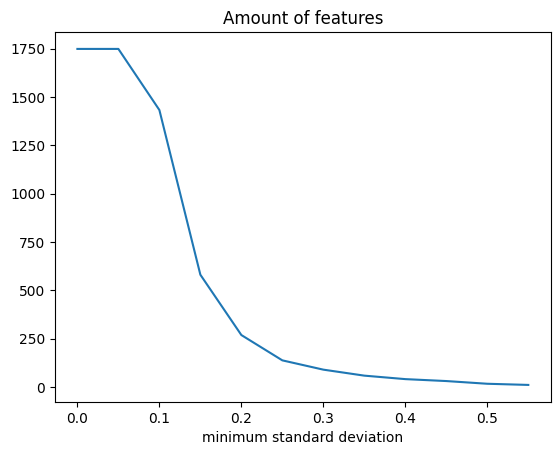

In [38]:
plt.plot([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55], X_size)
_ = plt.title("Amount of features")
_ = plt.xlabel("minimum standard deviation")

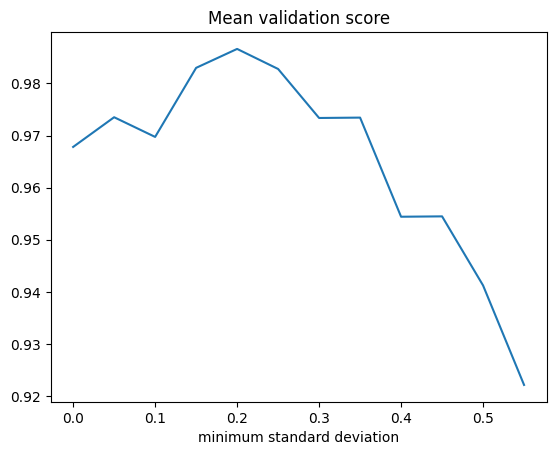

In [39]:
plt.plot([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55], results)
_ = plt.title("Mean validation score")
_ = plt.xlabel("minimum standard deviation")

In [58]:
to_drop = X_train.std() > .2
X_train_small = X_train.loc[:, to_drop]
X_test_small = X_test.loc[:, to_drop]
X_train_small_big = X_train * 0 + X_train_small
X_train_small_big = X_train_small_big.iloc[:, :-9].fillna(0)

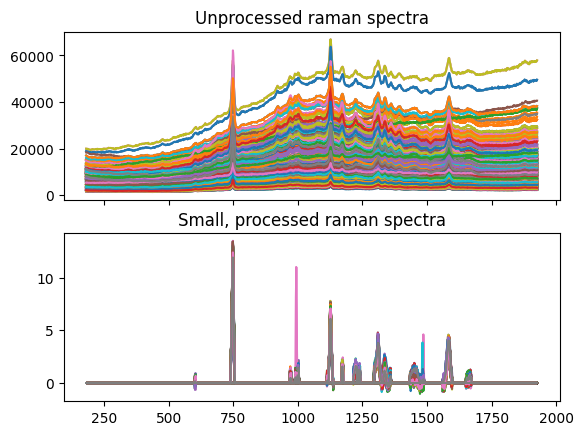

In [59]:
fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(experiments_train.columns.astype(int), experiments_train.transpose())
axs[0].set_title('Unprocessed raman spectra')
axs[1].plot(X_train_small_big.columns.astype(int), X_train_small_big.transpose())
_ = axs[1].set_title('Small, processed raman spectra')
plt.savefig('../images/random_forest/dropped_features.svg', format='svg', dpi=1200)

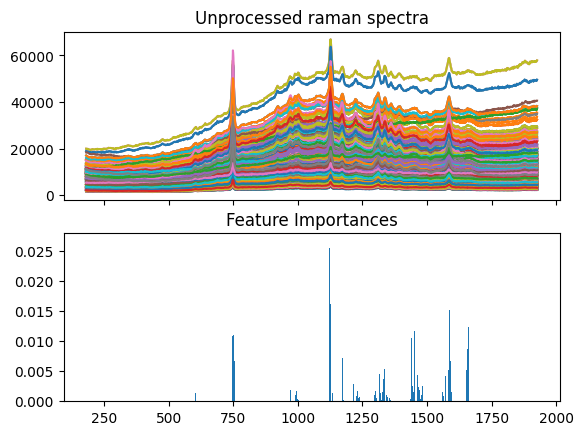

In [63]:
clf = RandomForestClassifier(**classifier_params)
clf.fit(X_train_small, truth_train.to_numpy().ravel())
_, axs = plt.subplots(2, sharex=True)
axs[0].plot(experiments_train.columns.astype(int), experiments_train.transpose())
axs[0].set_title('Unprocessed raman spectra')
axs[1].bar(X_train_small.iloc[:,2:].columns.astype(int), clf.feature_importances_[2:])
_ = axs[1].set_title('Feature Importances')
plt.savefig('../images/random_forest/feature_importance_dropped.svg', format='svg', dpi=1200)

In [65]:
scaler = StandardScaler()
scaler.fit(X_train_small)
X_train_small = scaler.transform(X_train_small)
X_test_small = scaler.transform(X_test_small)
evaluate_classifier_params(RandomForestClassifier, best_params, X_train_small, truth_train, X_test_small, truth_test, iters=20)

(1.0, 0.9915254237288134)